# LAB 3: Time-series and Reservoir Computing

## 2. Echo State Networks

1. Teacher forcing means giving to recurrent part of the model the correct answer so it can be consumed and help putting the reservoir in teh right direction. Feeding it's own predictions could corrupt the reservoir's state and prevent the output layer from being correctly trained. This is because even if the reservoir is not used for learning it's used to find the best feature maps and that can only be done with the correct intputs and outputs.

2. ridge regression is what is used to learn weights for the output layer. Ordinary least squares is used to estimate coefficients. Ridge regression modifies OLS by calculating coefficients that account for potentially correlated predictors. It corrects coefficients with high value is order to maximise generalisation and reduce the impact of a specific weights.

3. The spectral radius of the reservoir matrix $W$ should be bellow 1 : $\rho(W) <1$

4. Residual sum of squares (RSS) measures how well a linear regression model matches training data. A score of 0 indicates no error which might be linked to overfitting.


In [38]:
import numpy as np
import matplotlib.pyplot as plt

n_res = 1000 ## reservoir size
skip_first = 1000
spectral_radius = 0.8
input_scaling = 0.2

leak_rate = 1

ridge_coef = 1e-6


dataTimeSteps = np.arange(1,4001)
trainLen = 3000
def GroundTruth(t):
    return 0.5 * np.sin(t/4)

step_train = dataTimeSteps[:trainLen]
step_test = dataTimeSteps[trainLen:]
y_train = GroundTruth(step_train)
y_test = GroundTruth(step_test)

def generate_reservoir_states(y_data,
                              n_res=1000, input_scaling=0.2,
                              skip_first=1000, spectral_radius=0.8,
                              random_seed=42):

    len_data = len(y_data)
    n_in = 1 # number of input dimensions

    np.random.seed(random_seed)
    Win = np.random.uniform(-1, 1, size=(n_res, n_in + 1)) * input_scaling
    W = np.random.uniform(-1, 1, size=(n_res, n_res))
    eigvals = np.linalg.eigvals(W)
    W *= spectral_radius / np.max(np.abs(eigvals))
    reservoir_states = np.zeros((1 + n_in + n_res,
                                 len_data - skip_first))

    targets = y_data[skip_first:]  
    x = np.zeros((n_res, 1))
    for t in range(len_data):
        if t == 0:
            u = y_data[-1] ## initialize with last data point
        else:
            u = y_data[t-1] ## Using yewith the actual values for teaching forcing
        u_ext = np.vstack(([1.0], [u]))  # bias + input to feed the reservoir

        # reservoir update
        x = np.tanh(Win @ u_ext + W @ x)
        if t >= skip_first: ## skip initial data
            idx = t - skip_first
            reservoir_states[:, idx] = np.concatenate(([1.0], [u], x[:, 0]))

    return reservoir_states, targets,x,Win,W



def train_readout(reservoir_states, targets, ridge_coef):
    # Ridge regression to compute output weights
    print(f"reservoir_states.shape x reservoir_states.shape.T + ridge_coef * I.shape + targets.T.shape x reservoir_states.shape: {reservoir_states.shape} x {reservoir_states.T.shape} + ridge_coef *{ np.eye(reservoir_states.shape[0]).shape} + {targets.T.shape} x {reservoir_states.shape}")

    W_out = np.linalg.solve(
        reservoir_states @ reservoir_states.T + ridge_coef * np.eye(reservoir_states.shape[0]),
        targets @ reservoir_states.T 
    )
    return W_out

def predict(y_train, W_out, Win, W, x_last, testLen):

    x = x_last.copy()               # Start from last training state
    u = y_train[-1]                 # First input is last training output
    preds = np.zeros(testLen)
    for t in range(testLen):
        # reservoir update
        u_ext = np.vstack(([1.0], [u]))
        x = np.tanh(Win @ u_ext + W @ x)
        # compute output
        y = W_out @ np.concatenate(([1.0], [u], x[:, 0]))
        # store prediction
        preds[t] = y
        u = y

    return preds



## 3.Modeling of dynamic systems with ESNs

reservoir_states.shape x reservoir_states.shape.T + ridge_coef * I.shape + targets.T.shape x reservoir_states.shape: (1002, 2000) x (2000, 1002) + ridge_coef *(1002, 1002) + (2000,) x (1002, 2000)
Random Seed: 1, Root Mean Square Error on test set: 2.292198011026268e-06
reservoir_states.shape x reservoir_states.shape.T + ridge_coef * I.shape + targets.T.shape x reservoir_states.shape: (1002, 2000) x (2000, 1002) + ridge_coef *(1002, 1002) + (2000,) x (1002, 2000)
Random Seed: 2, Root Mean Square Error on test set: 2.0653683629710987e-06
reservoir_states.shape x reservoir_states.shape.T + ridge_coef * I.shape + targets.T.shape x reservoir_states.shape: (1002, 2000) x (2000, 1002) + ridge_coef *(1002, 1002) + (2000,) x (1002, 2000)
Random Seed: 3, Root Mean Square Error on test set: 2.0437818546280265e-06
reservoir_states.shape x reservoir_states.shape.T + ridge_coef * I.shape + targets.T.shape x reservoir_states.shape: (1002, 2000) x (2000, 1002) + ridge_coef *(1002, 1002) + (2000,) x (

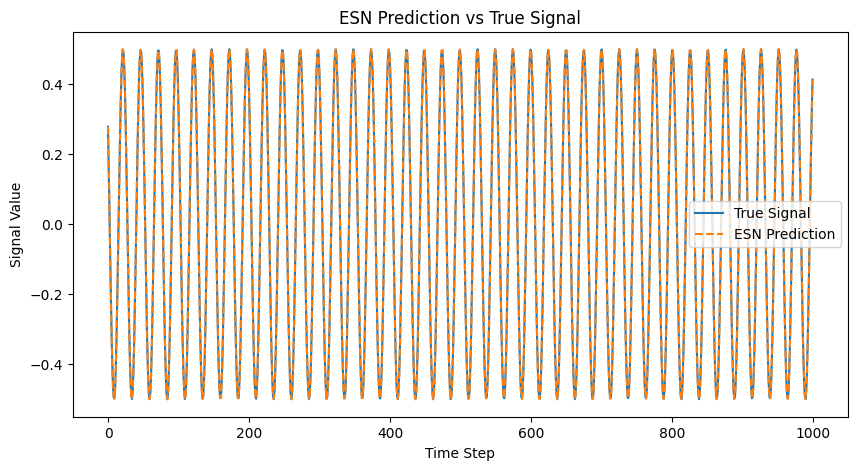

In [39]:
different_randomseeds = np.arange(1,11)
y_preds = []
for seed in different_randomseeds:
    reservoir_states, targets, x_last, Win, W = generate_reservoir_states(
    y_train, n_res, input_scaling, skip_first, spectral_radius, random_seed=seed
)

    W_out = train_readout(reservoir_states, targets, ridge_coef)

    # autonomous prediction for 1000 test steps
    y_pred = predict(
        y_train, W_out, Win, W, x_last, testLen=1000
    )


    error = np.sqrt(np.mean((y_pred.flatten() - y_test) ** 2))
    y_preds.append(y_pred)
    print(f'Random Seed: {seed}, Root Mean Square Error on test set: {error}')
    
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Signal')
plt.plot( np.mean(y_preds, axis=0).flatten(), label='ESN Prediction', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Signal Value')
plt.title('ESN Prediction vs True Signal')
plt.legend()
plt.show()


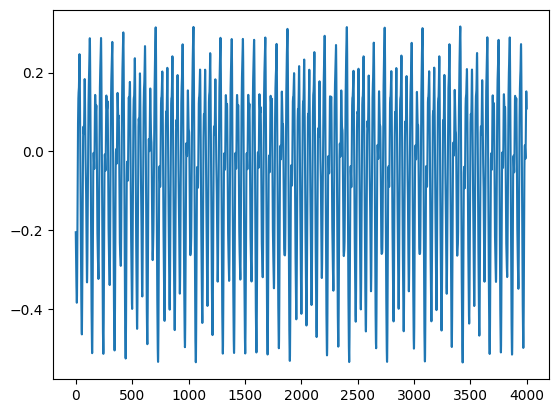

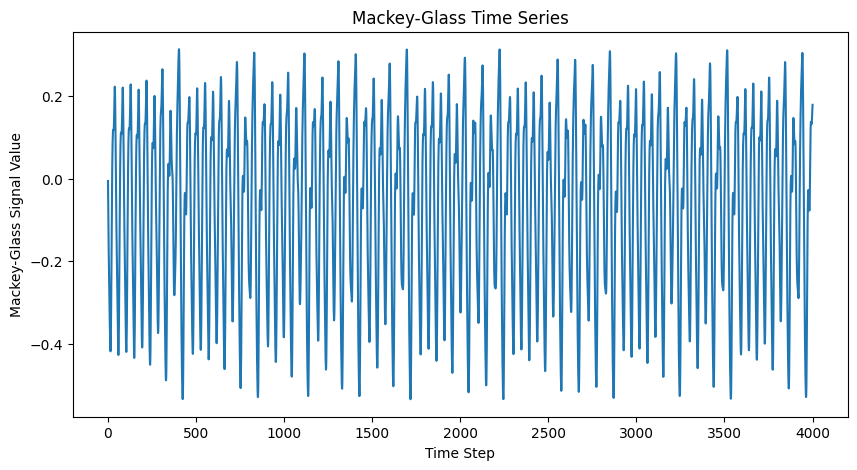

In [3]:
from lab3_Reservoir_computing.lab3_Reservoir_computing.mackey_glass_gen import mackey_glass,tau
len_data = 4000
y_data = mackey_glass(tau,len_data)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len_data+1), y_data)
plt.xlabel('Time Step')
plt.ylabel('Mackey-Glass Signal Value')
plt.title('Mackey-Glass Time Series')
plt.show()
 



Random Seed: 1, Root Mean Square Error on test set: 0.25935978970074414
Random Seed: 2, Root Mean Square Error on test set: 0.28533754963214436
Random Seed: 3, Root Mean Square Error on test set: 0.30193445692673915
Random Seed: 4, Root Mean Square Error on test set: 0.26683198996045693
Random Seed: 5, Root Mean Square Error on test set: 0.3260350224580662
Random Seed: 6, Root Mean Square Error on test set: 0.3241035905130607
Random Seed: 7, Root Mean Square Error on test set: 0.30973709989662923
Random Seed: 8, Root Mean Square Error on test set: 0.31434102246029944
Random Seed: 9, Root Mean Square Error on test set: 0.30218491077246923
Random Seed: 10, Root Mean Square Error on test set: 0.3076746739354304


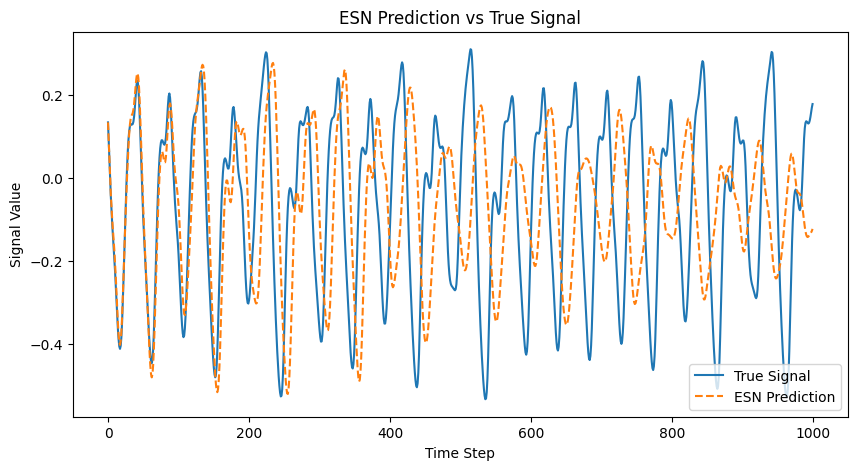

In [4]:
y_train = y_data[:3000]
y_test = y_data[3000:]
n_res = 1000
input_scaling = 0.2
spectral_radius = 0.8
skip_first = 1000


different_randomseeds = np.arange(1,11)
y_preds = []
for seed in different_randomseeds:
    reservoir_states, targets, x_last, Win, W = generate_reservoir_states(
    y_train, n_res, input_scaling, skip_first, spectral_radius, random_seed=seed
)

    W_out = train_readout(reservoir_states, targets, ridge_coef)

    # autonomous prediction for 1000 test steps
    y_pred = predict(
        y_train, W_out, Win, W, x_last, testLen=1000
    )


    error = np.sqrt(np.mean((y_pred.flatten() - y_test) ** 2))
    y_preds.append(y_pred)
    print(f'Random Seed: {seed}, Root Mean Square Error on test set: {error}')
    
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Signal')
plt.plot( np.mean(y_preds, axis=0).flatten(), label='ESN Prediction', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Signal Value')
plt.title('ESN Prediction vs True Signal')
plt.legend()
plt.show()

# 4. Time-series classification with ESNs

In [9]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("./data/UCRArchive_2018/SwedishLeaf/SwedishLeaf_TRAIN.tsv", sep="\t")
df_test = pd.read_csv("./data/UCRArchive_2018/SwedishLeaf/SwedishLeaf_TEST.tsv", sep="\t")
print(df_train.head())
y_train = df_train.iloc[:,0].values - 1
X_train = df_train.iloc[:,1:].values 
y_test = df_test.iloc[:,0].values - 1
X_test = df_test.iloc[:,1:].values

print(y_train.shape, X_train.shape)
print(np.unique(y_train), np.unique(y_test))

    4  1.5247497  1.5381197  1.4107898  1.2443998  1.0394698  0.86867588  \
0  11   2.214930    2.05051   1.842350   1.635900    1.43259    1.285370   
1  13   1.872010    1.72637   1.573640   1.396900    1.25221    1.083760   
2   4   1.731019    1.70220   1.553009   1.387209    1.14458    0.951378   
3  13   1.842670    1.74943   1.593560   1.420510    1.26840    1.118720   
4   8   1.267440    1.23729   1.155580   1.053950    1.02480    1.036910   

   0.66425693  0.48980096  0.26854901  ...  0.85770788  0.7606489  0.52103296  \
0    1.143260    1.006700    0.834105  ...    0.597998   0.712422    0.876184   
1    0.955383    0.796125    0.718198  ...    0.543164   0.660779    0.731471   
2    0.733035    0.559737    0.853391  ...   -0.157605   0.102225    0.317060   
3    0.972792    0.832494    0.711975  ...    0.546884   0.635829    0.755926   
4    0.991830    0.936324    1.009360  ...    0.591323   0.700378    0.699461   

   0.36217599  0.56148895  0.74166991  0.95520986  1.096

In [29]:
import numpy as np
import matplotlib.pyplot as plt

n_res = 800                      
input_scaling = 0.25        
spectral_radius = 0.99
ridge_coef = 1e-1
n_in = 1                    
n_classes = 15  # Swedish Leaf dataset

def generate_reservoir(n_res=800, n_in=1, input_scaling=0.25,
                      spectral_radius=0.99,
                      random_seed=42):
    np.random.seed(random_seed)
    Win = np.random.uniform(-1, 1, size=(n_res, n_in + 1)) * input_scaling
    W = np.random.uniform(-1, 1, size=(n_res, n_res))
    eigvals = np.linalg.eigvals(W)
    W *= spectral_radius / np.max(np.abs(eigvals))
    return Win, W

def run_reservoir(signal, Win, W):
    n_res = W.shape[0]
    x = np.zeros((n_res, 1))
    
    for t in range(len(signal)):
        u = signal[t]
        u_ext = np.vstack(([1.0], [u]))
        x = np.tanh(Win @ u_ext + W @ x)
    
    # Return last state as extended vector [bias; last_input; x]
    extended = np.vstack(([1.0], x))
    return extended[:, 0]  # flatten to 1D

def train_readout(reservoir_states, targets, ridge_coef):
    A = reservoir_states @ reservoir_states.T
    B = targets @ reservoir_states.T
    W_out = np.linalg.solve(A + ridge_coef * np.eye(A.shape[0]), B.T).T
    return W_out

def predict_class(signal, Win, W, W_out):
    x = run_reservoir(signal, Win, W)
    y = W_out @ x
    return np.argmax(y)


In [30]:

from sklearn.metrics import accuracy_score

accuracies = []

# One-hot encoding
def one_hot_encode(labels, n_classes):
    N = len(labels)
    oh = np.zeros((n_classes, N))
    for i, lbl in enumerate(labels):
        oh[int(lbl), i] = 1.0
    return oh


Y_train_oh = one_hot_encode(y_train, n_classes)  # shape: (n_classes, N_train)

for seed in range(10):
    print(f"Running ESN experiment seed {seed}...")
    
    # 1. Build reservoir
    Win, W = generate_reservoir(n_res, n_in, input_scaling, spectral_radius, seed)
    
    # 2. Compute last reservoir state for each training signal
    reservoir_states = []
    for signal in X_train:
        sx = run_reservoir(signal, Win, W)
        reservoir_states.append(sx[:, None])  # keep column form
    
    reservoir_states = np.hstack(reservoir_states)  # shape (M, N_train)
    
    # 3. Train readout
    W_out = train_readout(reservoir_states, Y_train_oh, ridge_coef)
    
    # 4. Test phase: classification
    preds = []
    for signal in X_test:
        c = predict_class(signal, Win, W, W_out)
        preds.append(c)
    
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(" → accuracy:", acc)

print("\n--------------------------------------")
print("Average accuracy over 10 ESNs:", np.mean(accuracies))
print("--------------------------------------")

Running ESN experiment seed 0...
 → accuracy: 0.7467948717948718
Running ESN experiment seed 1...


KeyboardInterrupt: 